In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.fftpack

import tensorflow as tf
from tensorflow import keras

#Set the seed for reproductability
np.random.seed(0)

### Define the NN - a simple Multi Layer Perceptron with 3 layers


In [2]:
# Time series prediction model
def dnn_keras_tspred_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.sigmoid,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(32, activation=tf.nn.sigmoid),
    keras.layers.Dense(8, activation=tf.nn.sigmoid),
    keras.layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  model.summary()
  return model

Create data

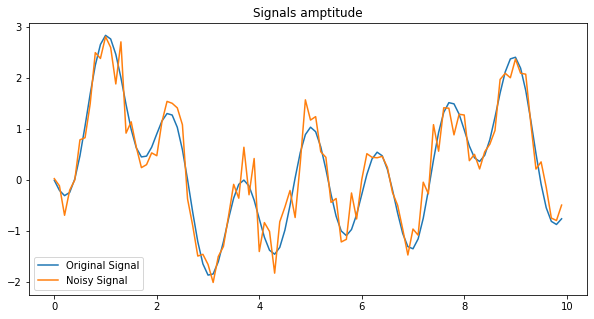

In [3]:
num_train_data = 4000
num_test_data = 1000
timestep = 0.1
tm =  np.arange(0, (num_train_data+num_test_data)*timestep, timestep)
#The original signal
y = np.sin(tm) + np.sin(tm*np.pi/2) + np.sin(tm*(-3*np.pi/2))
# y = np.sin(tm)

SNR = 10
# SNR = 30
# The noise signal
ypn = y + np.random.normal(0,10**(-SNR/20),len(y))

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(tm[0:100],y[0:100], label='Original Signal')
ax.plot(tm[0:100],ypn[0:100], label='Noisy Signal')
ax.set_title('Signals amptitude')
ax.legend()

In [4]:
# prepare the train_data and train_labels
dnn_numinputs = 64
num_train_batch = 0
train_data = []
for k in range(num_train_data-dnn_numinputs-1):
  train_data = np.concatenate((train_data,ypn[k:k+dnn_numinputs]))
  num_train_batch = num_train_batch + 1
train_data = np.reshape(train_data, (num_train_batch,dnn_numinputs))
train_labels = y[dnn_numinputs:num_train_batch+dnn_numinputs]

print(train_data.shape, train_labels.shape, y.shape, ypn.shape)

(3935, 64) (3935,) (5000,) (5000,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6,513
Trainable params: 6,513
Non-trainable params: 0
_________________________________________________________________
DNN training done. Time elapsed:  13.274942 s


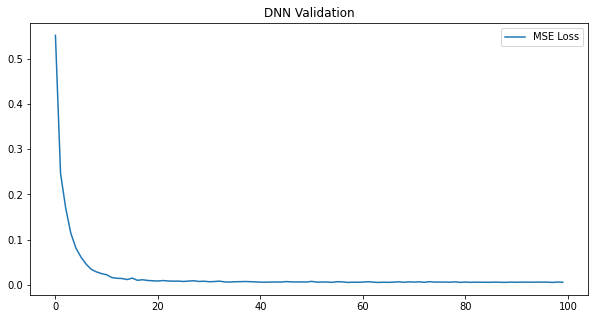

In [5]:
model = dnn_keras_tspred_model()

EPOCHS = 100
strt_time = datetime.datetime.now()
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                  validation_split=0.2, verbose=0,
                  callbacks=[])
curr_time = datetime.datetime.now()
timedelta = curr_time - strt_time
dnn_train_time = timedelta.total_seconds()

print("DNN training done. Time elapsed: ", timedelta.total_seconds(), "s")

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(history.epoch, np.array(history.history['val_loss']), label = 'MSE Loss')
ax.set_title('DNN Validation')
ax.legend()


(935, 64) (935,)
30/30 [==============================] - 0s 753us/step


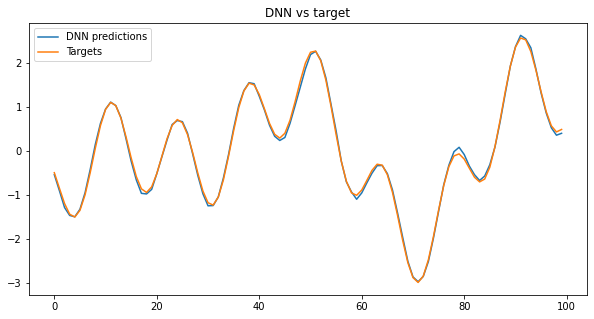

In [6]:
# test how well DNN predicts now
num_test_batch = 0
strt_idx = num_train_batch
test_data=[]
for k in range(strt_idx, strt_idx+num_test_data-dnn_numinputs-1):
  test_data = np.concatenate((test_data,ypn[k:k+dnn_numinputs]));
  num_test_batch = num_test_batch + 1
test_data = np.reshape(test_data, (num_test_batch, dnn_numinputs))
test_labels = y[strt_idx+dnn_numinputs:strt_idx+num_test_batch+dnn_numinputs]

print(test_data.shape, test_labels.shape)


dnn_predictions = model.predict(test_data).flatten()
keras_dnn_err = test_labels - dnn_predictions

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(dnn_predictions[0:100], label='DNN predictions')
ax.plot(test_labels[0:100], label='Targets')
ax.set_title('DNN vs target')
ax.legend()


Least Mean Squares (LMS) algorithm

(64,) (1064,) (5000,)
(1064,)
(1064,)


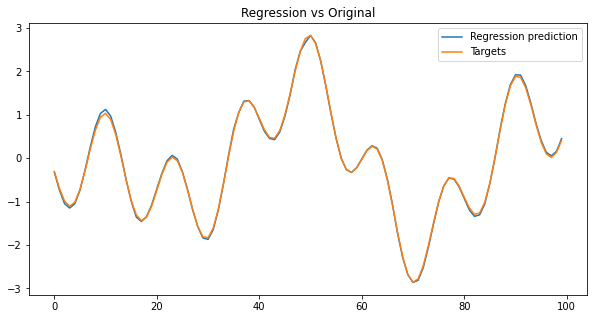

In [7]:
M = 1000
L = 64
yrlms = np.zeros(M+L)
m, c = np.zeros(M+L), np.zeros(M+L)
#wn = np.random.normal(0,1,L)
wn = np.zeros(L)
print(wn.shape, yrlms.shape, y.shape)
mu = 0.005
for k in range(L,M+L):
  yrlms[k] = np.dot(ypn[k-L:k],wn)
  e = ypn[k]- yrlms[k]
  wn=wn+(mu*ypn[k-L:k]*e)

print(yrlms.shape)

# Solve y = mx + c => y = Ap , A = [[x 1]] & p = [[m], [c]]
A = np.zeros(M+L)
for k in range(L,M+L):
  A = np.vstack([y[k-L:k], np.ones(len(y[k-L:k]))]).T
  # print(A.shape, y[k-L:k].shape)
  m[k], c[k] = np.linalg.lstsq(A, ypn[k-L:k], rcond=None)[0]

def prediction(x, m, c):
  return m*x + c

preds = prediction(y[0:M+L], m, c)
print(preds.shape)

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(preds[600:700], label='Regression prediction')
ax.plot(y[600:700], label='Targets')
ax.set_title('Regression vs Original')
ax.legend()

Compare Prediction results


We calculate the Signal to Noise Ratio SNR:

$$SNR = MSE - SigPow = 10*log_{10}\frac{1}{N}\sum|target|^2 - 10* log_{10} \frac{1}{N}\sum |pred - target|^2$$

Neural network SNR: 25.005508917038387
LMS Prediction SNR: 26.53510335809072


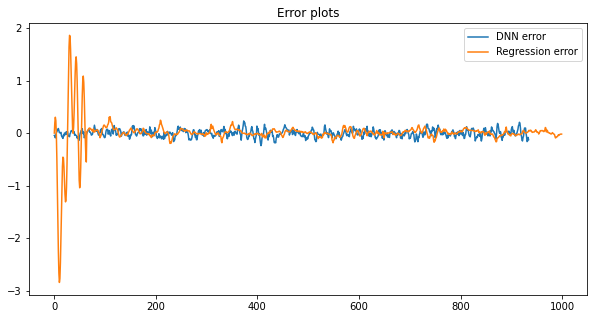

In [8]:
dnn_err = dnn_predictions - test_labels
# lms_err = yrlms[0:M] - y[0:M]
lms_err = preds[0:M] - y[0:M]

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(dnn_err, label='DNN error')
ax.plot(lms_err, label='Regression error')
ax.set_title('Error plots')
ax.legend()
dnn_mse = 10*np.log10(np.mean(pow(np.abs(dnn_err),2)))
dnn_sigpow = 10*np.log10(np.mean(pow(np.abs(test_labels),2)))
lms_mse = 10*np.log10(np.mean(pow(np.abs(lms_err[200:M]),2)))
lms_sigpow = 10*np.log10(np.mean(pow(np.abs(y[200:M]),2)))

#print(dnn_mse, dnn_sigpow, lms_mse, lms_sigpow)
print("Neural network SNR:", dnn_sigpow - dnn_mse)
print("LMS Prediction SNR:", lms_sigpow - lms_mse)

Fast Fourier Transform 

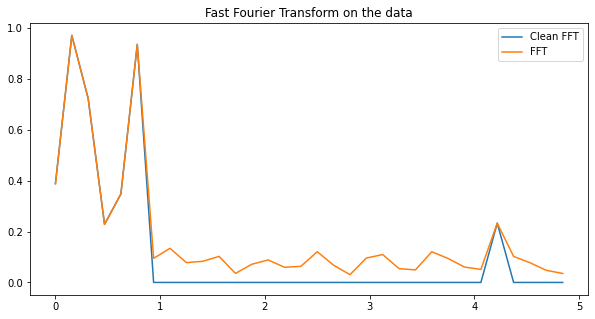

In [11]:
# 64 point FFT
N = 64

# Using the same noisy signal used for LMS
yf = scipy.fftpack.fft(ypn[0:N])

# Let us remove noise, easy to do at the FFT output
y_clean = np.zeros(N,dtype=complex)
cidx = np.where(np.abs(yf)>(N*0.2/2))[0]
y_clean[cidx]=yf[cidx]

# 0 to Fs/2, Fs = 1/Ts
# xf = np.linspace(0.0, 1.0/(2*timestep), int(N/2))
xf = scipy.fftpack.fftfreq(N, timestep)[:N // 2]

# Plotting only from 0 to Fs/2

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(xf, 2.0/N * np.abs(y_clean[:N//2]), label = 'Clean FFT')
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]), label = 'FFT')
ax.set_title('Fast Fourier Transform on the data')
ax.legend()

In [20]:
def dnn_keras_fft_model():
  model = keras.Sequential([
    keras.layers.Dense(NFFT*2, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(NFFT*2, activation=tf.nn.relu),
    keras.layers.Dense(NFFT*2)
  ])
  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae']) 
  model.summary()
  return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
Total params: 49,536
Trainable params: 49,536
Non-trainable params: 0
_________________________________________________________________
DNN training done. Time elapsed:  36.313957 s


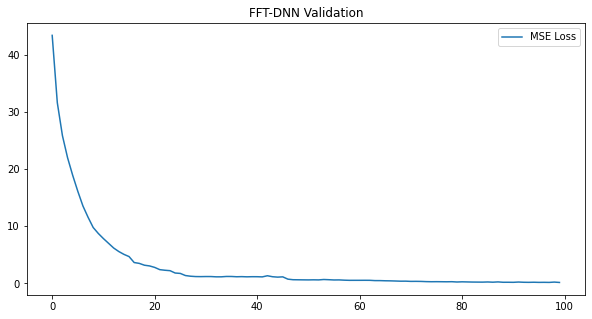

In [21]:
# Train the DNN for 16 point FFT
NFFT = 64
num_train_batch = 1
num_batches = 10000
train_data = np.random.normal(0,1,(num_batches, NFFT*2))
train_labels = np.random.normal(0,1,(num_batches, NFFT*2))
model = dnn_keras_fft_model()
for k in range(num_train_batch):
  for el in range(num_batches):
    fftin = train_data[el,0::2] + 1j*train_data[el,1::2]
    train_labels[el,0::2]=scipy.fftpack.fft(fftin).real
    train_labels[el,1::2]=scipy.fftpack.fft(fftin).imag
  EPOCHS = 100
  strt_time = datetime.datetime.now()
  history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[])
  curr_time = datetime.datetime.now()
  timedelta = curr_time - strt_time
  dnn_train_time = timedelta.total_seconds()
  print("DNN training done. Time elapsed: ", timedelta.total_seconds(), "s")

  fix, ax = plt.subplots(figsize=(10,5))
  ax.plot(history.epoch, np.array(history.history['val_loss']), label = 'MSE Loss')
  ax.set_title('FFT-DNN Validation')
  ax.legend()

  train_data = np.random.normal(0,1,(num_batches, NFFT*2))

1/1 [==============================] - 0s 38ms/step


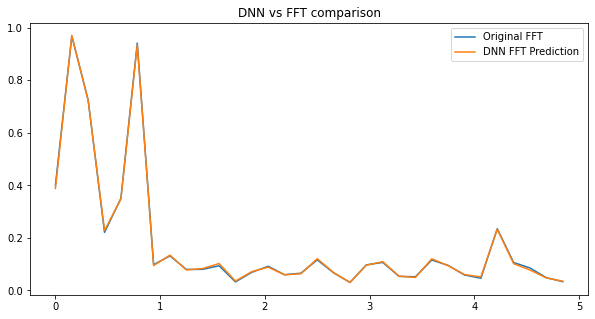

In [22]:
fftin = np.zeros((1,2*NFFT))
fftin[:,0::2]=ypn[0:NFFT]
fftout = model.predict(fftin).flatten()
fftout = fftout[0::2] + 1j*fftout[1::2]

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(xf, 2.0/NFFT * np.abs(fftout[0:NFFT//2]), label = 'Original FFT')
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]), label = 'DNN FFT Prediction')
ax.set_title('DNN vs FFT comparison')
ax.legend()


Compare FFT & NN Outputs


32/32 [==============================] - 0s 933us/step
Neural Network SNR compare to SciPy FFT:  25.82636700073209


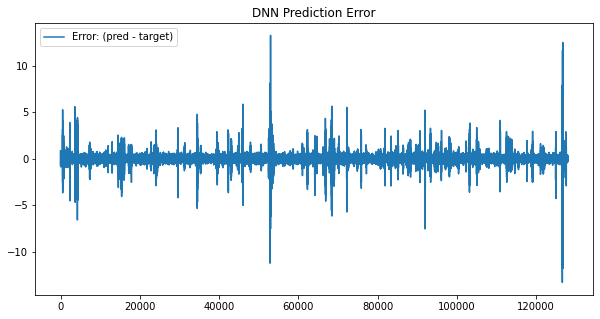

In [25]:
test_data = np.random.normal(0,1,(1000, NFFT*2))
test_labels = np.random.normal(0,1,(1000, NFFT*2))
for el in range(1000):
  fftin = test_data[el,0::2] + 1j*test_data[el,1::2]
  test_labels[el,0::2]=scipy.fftpack.fft(fftin).real
  test_labels[el,1::2]=scipy.fftpack.fft(fftin).imag

dnn_out = model.predict(test_data).flatten()
keras_dnn_err = test_labels.flatten() - dnn_out

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(keras_dnn_err, label = 'Error: (pred - target)')
ax.set_title('DNN Prediction Error')
ax.legend()

dnn_fft_mse = 10*np.log10(np.mean(pow(np.abs(keras_dnn_err),2)))
labels_sigpow = 10*np.log10(np.mean(pow(np.abs(test_labels.flatten()),2)))
print("Neural Network SNR compare to SciPy FFT: ", labels_sigpow - dnn_fft_mse)

In [ ]:
asdasd

